# Cancer Classification Using Gene Expression Data

In this notebook, we'll walk through the process of using machine learning to classify different types of cancer using gene expression data. 
We'll be using a small dataset with 8000 genes and 5 cancer types as a starting point. This tutorial will cover data preprocessing, feature 
selection, training a RandomForestClassifier, and evaluating the model's performance.

## Step 0: Install Required Libraries

In [1]:
%%capture
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn

## Step 1: Import Required Libraries

First, we'll import all the necessary libraries for data manipulation, visualization, machine learning, and evaluation.

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (balanced_accuracy_score, f1_score, precision_score, recall_score,
                             classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, auc)

# Configure matplotlib
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)
mpl.rcParams.update({'font.size': 15})
plt.ioff()

## Step 2: Load the Datasets

We'll load both the small and large datasets. The small dataset has 8000 gene columns, while the large dataset has over 20000 genes. For simplicity, we will start with the small dataset.

In [3]:
data_directory = '/path/to/your/dataset'  # Update this with the correct path
df_small = pd.read_csv(os.path.join(data_directory, 'cancer_gene_expression.csv'))
df_large = pd.read_csv(os.path.join(data_directory, 'data.csv'))
labels_df = pd.read_csv(os.path.join(data_directory, 'labels.csv'))

# Display the shape of the datasets
print(f"Small dataset shape: {df_small.shape}")
print(f"Large dataset shape: {df_large.shape}")
print(f"Labels shape: {labels_df.shape}")

Small dataset shape: (801, 8001)
Large dataset shape: (801, 20532)
Labels shape: (801, 2)


## Step 3: Explore the Data

It's important to understand the structure of the data before proceeding with preprocessing. Let's take a look at the first few rows and check for missing values.

In [4]:
# Explore the first few rows
display(df_small.head())
display(labels_df.head())

# Check for missing values
missing_values = df_small.isnull().sum()
print(f"Missing columns: {missing_values[missing_values > 0]}")

,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,gene_10,...,gene_7992,gene_7993,gene_7994,gene_7995,gene_7996,gene_7997,gene_7998,gene_7999,gene_8000,Cancer_Type
0,0.0,0.0,0.0,2.088413,0.0,0.0,0.0,0.0,0.550605,2.815760,...,11.558803,8.881802,6.014840,6.643534,11.740624,7.065012,9.932659,6.928584,2.088413,KIRC
1,0.0,0.0,0.0,3.205955,0.0,0.0,0.0,0.0,0.425244,2.354396,...,11.062829,9.032864,5.054193,6.432320,12.104985,7.300746,9.872796,5.039231,2.448002,KIRC
2,0.0,0.0,0.0,4.746646,0.0,0.0,0.0,0.0,2.639417,1.657091,...,12.497640,7.198160,0.943434,7.371690,11.202356,8.426588,11.176890,3.119738,4.433988,BRCA
3,0.0,0.0,0.0,1.173191,0.0,0.0,0.0,0.0,1.527371,2.732899,...,11.261713,8.725676,6.300418,6.036451,11.732303,7.559469,9.596453,2.863046,3.380342,KIRC
4,0.0,0.0,0.0,1.366532,0.0,0.0,0.0,0.0,0.000000,3.388355,...,12.241965,7.685204,5.142948,6.355788,11.493950,8.139444,10.189256,6.544487,0.839395,COAD


,Unnamed: 0,Class
0,sample_0,PRAD
1,sample_1,LUAD
2,sample_2,PRAD
3,sample_3,PRAD
4,sample_4,BRCA


Missing columns: Series([], dtype: int64)


## Step 4: Visualizing Cancer Type Distribution

Let's visualize the distribution of cancer types in the dataset to see if there's any imbalance.

In [5]:
counts = df_small['Cancer_Type'].value_counts()
counts

Cancer_Type
BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: count, dtype: int64

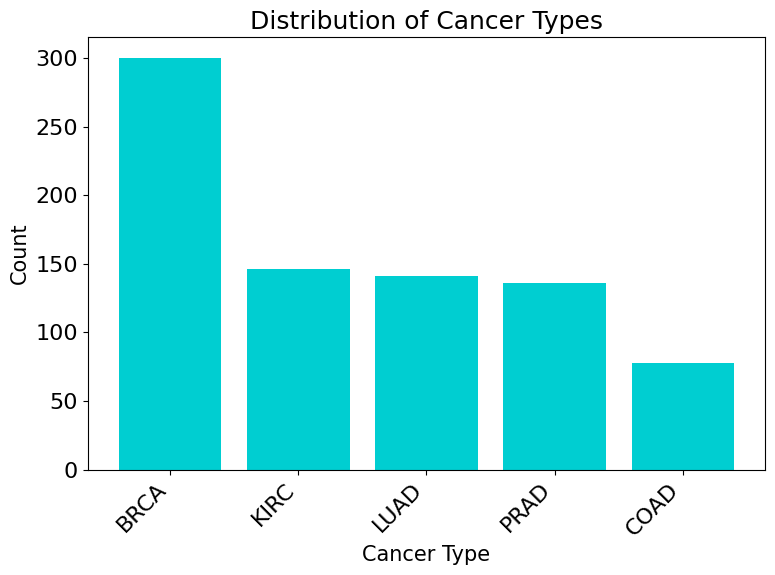

In [6]:
plt.figure(figsize=(8, 6))
plt.bar(counts.index, counts.values, color="Darkturquoise")
plt.title("Distribution of Cancer Types")
plt.xlabel('Cancer Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Step 5: Data Preprocessing

We'll now separate the features and labels, and then encode the labels into numerical format since machine learning models require numerical input.

In [7]:
# Separate features and labels
X = df_small.iloc[:, :-1]
y = df_small.iloc[:, -1]

In [8]:
# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
labels = label_encoder.classes_
print(f"Labels: {labels}")

Labels: ['BRCA' 'COAD' 'KIRC' 'LUAD' 'PRAD']


## Step 6: Train-Test Split and Data Normalization

Next, we'll split the data into training and test sets and normalize the feature values between 0 and 1 using MinMaxScaler.

In [9]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Normalize the data
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

## Step 7: Feature Selection Using Mutual Information

We'll select the top n features based on mutual information scores. This helps us reduce the number of irrelevant features.

In [10]:
MI_scores = mutual_info_classif(X_train_norm, y_train)

# Select top 50 features
n_features = 50
top_feature_indices = np.argsort(MI_scores)[::-1][:n_features]

X_train_selected = X_train_norm[:, top_feature_indices]
X_test_selected = X_test_norm[:, top_feature_indices]

## Step 8: Model Training and Prediction

We'll train a RandomForestClassifier using the OneVsRest strategy and then make predictions on the test data.

In [11]:
RF = OneVsRestClassifier(RandomForestClassifier(max_features=0.2, random_state=42))
RF.fit(X_train_selected, y_train)

# Make predictions
y_pred = RF.predict(X_test_selected)
y_pred_proba = RF.predict_proba(X_test_selected)

## Step 9: Model Evaluation

Let's evaluate the performance of our model using metrics such as accuracy, precision, recall, and F1-score. We'll also display the classification report.

In [12]:
accuracy = balanced_accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Balanced Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification report
report = classification_report(y_test, y_pred, target_names=labels)
print("\nClassification Report:\n")
print(report)

Balanced Accuracy: 0.9167
Precision: 0.9366
Recall: 0.9317
F1 Score: 0.9309

Classification Report:

              precision    recall  f1-score   support

        BRCA       0.88      1.00      0.94        60
        COAD       0.94      0.94      0.94        16
        KIRC       0.96      0.96      0.96        28
        LUAD       0.95      0.83      0.89        24
        PRAD       1.00      0.85      0.92        33

    accuracy                           0.93       161
   macro avg       0.95      0.92      0.93       161
weighted avg       0.94      0.93      0.93       161



## Step 10: Confusion Matrix and ROC Curves

We'll plot the confusion matrix to visually inspect the performance of the classifier. We'll also plot the ROC curves for each class to assess model performance in distinguishing between classes.

In [13]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
df_cm

,BRCA,COAD,KIRC,LUAD,PRAD
BRCA,60,0,0,0,0
COAD,0,15,0,1,0
KIRC,1,0,27,0,0
LUAD,3,1,0,20,0
PRAD,4,0,1,0,28


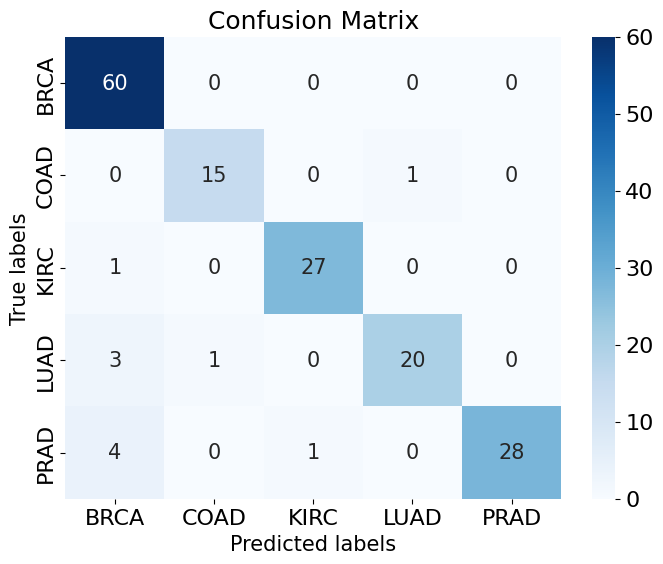

In [14]:
# Visualize Confusion Matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

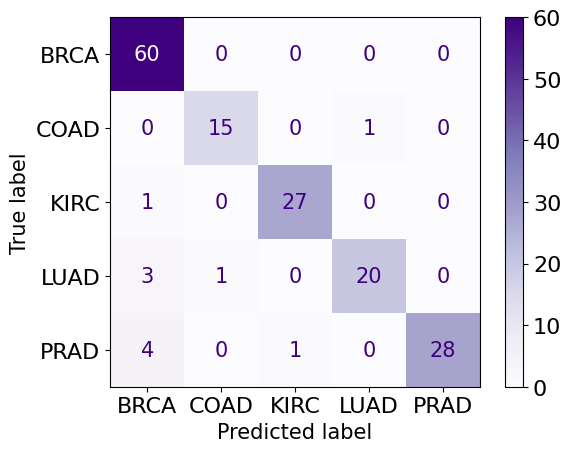

In [15]:
# Visualize Confusion Matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_estimator(
        RF, X_test_selected, y_test, cmap='Purples', display_labels=labels)
plt.show()

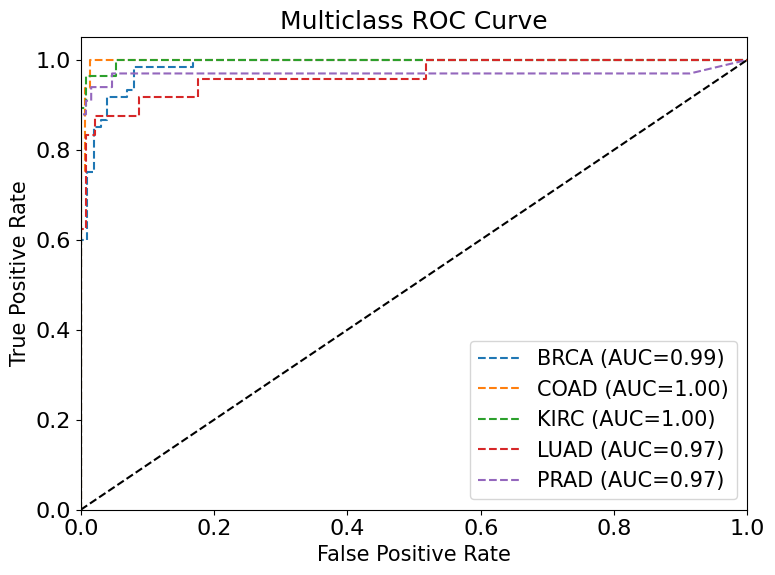

In [16]:
# ROC Curves and AUC for each class
y_test_bin = label_binarize(y_test, classes=np.unique(y_encoded))

fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curves
plt.figure(figsize=(8, 6))
for i in range(len(labels)):
    plt.plot(fpr[i], tpr[i], linestyle='--', label=f'{labels[i]} (AUC={roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Multiclass ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()